In [132]:
import surprise as sp
import pyspark as ps
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = (
    ps.sql.SparkSession.builder
    .config('spark.driver.memory', '1g')
    .config('spark.executor.memory', '1g')
    # .master("local[8]")
    .appName("test-scikit-surprise")
    .getOrCreate()
)

In [62]:
ratings_df = spark.read.parquet('../data/ratings')
ratings_df.show()

+------+----+------+
|  user|item|rating|
+------+----+------+
|259825|1627|     4|
|394869|1627|     1|
|106643|3534|     1|
| 85853| 485|     1|
|   200| 485|     3|
|   182| 485|     3|
| 53398|1621|     4|
| 11280| 485|     3|
|  8994| 741|     3|
| 11520| 741|     3|
| 21380|2693|     5|
| 14094|2693|     1|
|359855|1871|     5|
|  5227|1521|     3|
|352906|1521|     5|
|243591|1871|     4|
|  1301|1871|     4|
|169784|1871|     5|
|  5042|1521|     4|
|278755|1746|     5|
+------+----+------+
only showing top 20 rows



In [65]:
# Load restaurant metadata
restaurants_df = spark.read.parquet('../data/restaurants')

# Load restaurant ids into mapping dataframe
restaurant_id_map = []
index = 0
with open('../data/product_labels.txt') as f:
    for line in f:
        restaurant_id = line.strip()
        restaurant_id_map.append((restaurant_id, index))
        index += 1

restaurant_id_map_df = spark.createDataFrame(restaurant_id_map, ['id', 'item'])

restaurants_with_id_df = restaurants_df.join(restaurant_id_map_df, on='id')

restaurants_with_id_df.show()

+--------------------+--------------------+--------------------+--------------+------------------+--------------------+---------+--------------------+--------------------+------------+-----+------+------------+------------+--------------------+----+
|                  id|          categories|         coordinates| display_phone|          distance|           image_url|is_closed|            location|                name|       phone|price|rating|review_count|transactions|                 url|item|
+--------------------+--------------------+--------------------+--------------+------------------+--------------------+---------+--------------------+--------------------+------------+-----+------+------------+------------+--------------------+----+
|brendas-french-so...|[[breakfast_brunc...|[37.7829016035273...|(415) 345-8100|    510.7695611352|https://s3-media1...|    false|[652 Polk St H,,,...|Brenda's French S...|+14153458100|   $$|   4.0|        7796|          []|https://www.yelp....|   0|


In [66]:
ratings_pdf = ratings_df.toPandas()
restaurants_with_id_pdf = restaurants_with_id_df.toPandas()

In [13]:
reader = sp.Reader(line_format='user item rating', rating_scale=(1,5))
data = sp.Dataset.load_from_df(ratings_pdf[['user','item','rating']], reader)
data.split(n_folds=5)

# We'll use the famous SVD algorithm.
algo = sp.SVD()

# Evaluate performances of our algorithm on the dataset.
perf = sp.evaluate(algo, data, measures=['RMSE', 'MAE', 'FCP'])

sp.print_perf(perf)

Evaluating RMSE, MAE, FCP of algorithm SVD.

------------
Fold 1
RMSE: 1.1339
MAE:  0.8948
FCP:  0.5504
------------
Fold 2
RMSE: 1.1353
MAE:  0.8958
FCP:  0.5594
------------
Fold 3
RMSE: 1.1325
MAE:  0.8934
FCP:  0.5560
------------
Fold 4
RMSE: 1.1354
MAE:  0.8958
FCP:  0.5569
------------
Fold 5
RMSE: 1.1365
MAE:  0.8964
FCP:  0.5567
------------
------------
Mean RMSE: 1.1347
Mean MAE : 0.8952
Mean FCP : 0.5559
------------
------------
        Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    
RMSE    1.1339  1.1353  1.1325  1.1354  1.1365  1.1347  
MAE     0.8948  0.8958  0.8934  0.8958  0.8964  0.8952  
FCP     0.5504  0.5594  0.5560  0.5569  0.5567  0.5559  


In [29]:
print(algo.pu.shape)
print(type(algo.pu))
print(algo.qi.shape)
print(type(algo.qi))
print(algo.bu.shape)
print(type(algo.bu))
print(algo.bi.shape)
print(type(algo.bi))
print(algo.trainset.global_mean)

(447903, 100)
<class 'numpy.ndarray'>
(5633, 100)
<class 'numpy.ndarray'>
(447903,)
<class 'numpy.ndarray'>
(5633,)
<class 'numpy.ndarray'>
3.8437702708


In [30]:
print(algo.pu.mean(), algo.pu.std(), algo.pu.min(), algo.pu.max())
print(algo.qi.mean(), algo.qi.std(), algo.qi.min(), algo.qi.max())
print(algo.bu.mean(), algo.bu.std(), algo.bu.min(), algo.bu.max())
print(algo.bi.mean(), algo.bi.std(), algo.bi.min(), algo.bi.max())

1.11283811115e-05 0.10221515398 -0.632437552024 0.632745359891
-0.000190973182749 0.1787676485 -1.26310230366 1.35552804301
-0.000407575321978 0.154984133721 -1.64604323561 1.39740106161
-0.045250038489 0.471635950249 -2.32364598402 1.08302961424


In [35]:
best_idx = np.argmax(algo.bi)
worst_idx = np.argmin(algo.bi)
print(best_idx, worst_idx)
print(algo.bi[best_idx], algo.bi[worst_idx])

3030 4248
1.08302961424 -2.32364598402


In [134]:
latent_feature_stats = []
for i in range(100):
    latent_feature_stats.append((
        i,
        np.mean(algo.qi[:,i]),
        np.std(algo.qi[:,i]),
        np.min(algo.qi[:,i]),
        np.max(algo.qi[:,i])
    ))
pprint(sorted(latent_feature_stats, key=lambda x: x[2])[::-1])

[(1,
  -0.004089527902321706,
  0.18410698045180171,
  -1.2078317359761741,
  0.79031368791172341),
 (2,
  0.00054042749472026086,
  0.18378546842181384,
  -0.9971179019732187,
  0.84622271915773095),
 (55,
  0.0041622417348315703,
  0.1827197005663064,
  -0.82598047682514308,
  1.0697543228813877),
 (27,
  0.003152773073643748,
  0.18248466490864326,
  -0.994150723871987,
  0.98810815715668476),
 (95,
  0.0039238022244529542,
  0.18229591815075422,
  -1.0460537465130051,
  0.92152905531968787),
 (66,
  0.0022796309960021678,
  0.18214595880418794,
  -0.90033907738503272,
  1.12869772228878),
 (15,
  0.0010131258173113182,
  0.18195760879190365,
  -0.88502061309489277,
  0.83045722009012035),
 (36,
  -0.00062448468826764862,
  0.18179904828732649,
  -0.80297674273534725,
  1.0064540597606297),
 (72,
  0.0005004180643786775,
  0.18166936579272386,
  -1.0568589436888518,
  0.98788307430252187),
 (49,
  -0.0010141840152511662,
  0.18163339124583786,
  -0.98942531665434019,
  1.09781594635

In [67]:
restaurants_with_id_pdf.head()

,id,categories,coordinates,display_phone,distance,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url,item
0,brendas-french-soul-food-san-francisco,"[(breakfast_brunch, Breakfast & Brunch), (fren...","(37.7829016035273, -122.419043442957)",(415) 345-8100,510.769561,https://s3-media1.fl.yelpcdn.com/bphoto/YT8ho0...,False,"(652 Polk St H, , , San Francisco, US, [652 Po...",Brenda's French Soul Food,+14153458100,$$,4.0,7796,[],https://www.yelp.com/biz/brendas-french-soul-f...,0
1,tartine-bakery-and-cafe-san-francisco,"[(bakeries, Bakeries), (cafes, Cafes), (desser...","(37.7614250022004, -122.424051321456)",(415) 487-2600,1039.959209,https://s3-media1.fl.yelpcdn.com/bphoto/vTLu8G...,False,"(600 Guerrero St, , , San Francisco, US, [600 ...",Tartine Bakery & Cafe,+14154872600,$$,4.0,6627,[],https://www.yelp.com/biz/tartine-bakery-and-ca...,1
2,burma-superstar-san-francisco-2,"[(burmese, Burmese)]","(37.782787322998, -122.462539672852)",(415) 387-2147,2105.812056,https://s3-media1.fl.yelpcdn.com/bphoto/x6rvBD...,False,"(309 Clement St, , , San Francisco, US, [309 C...",Burma Superstar,+14153872147,$$,4.0,5764,[],https://www.yelp.com/biz/burma-superstar-san-f...,2
3,house-of-prime-rib-san-francisco,"[(tradamerican, American (Traditional)), (stea...","(37.79338, -122.4225)",(415) 885-4605,1249.561743,https://s3-media4.fl.yelpcdn.com/bphoto/HLrjaM...,False,"(1906 Van Ness Ave, , , San Francisco, US, [19...",House of Prime Rib,+14158854605,$$$,4.0,5765,[],https://www.yelp.com/biz/house-of-prime-rib-sa...,3
4,san-tung-san-francisco-2,"[(chinese, Chinese), (chicken_wings, Chicken W...","(37.76367, -122.46896)",(415) 242-0828,2337.123621,https://s3-media4.fl.yelpcdn.com/bphoto/P5_EgB...,False,"(1031 Irving St, , , San Francisco, US, [1031 ...",San Tung,+14152420828,$$,4.0,5525,[],https://www.yelp.com/biz/san-tung-san-francisc...,4


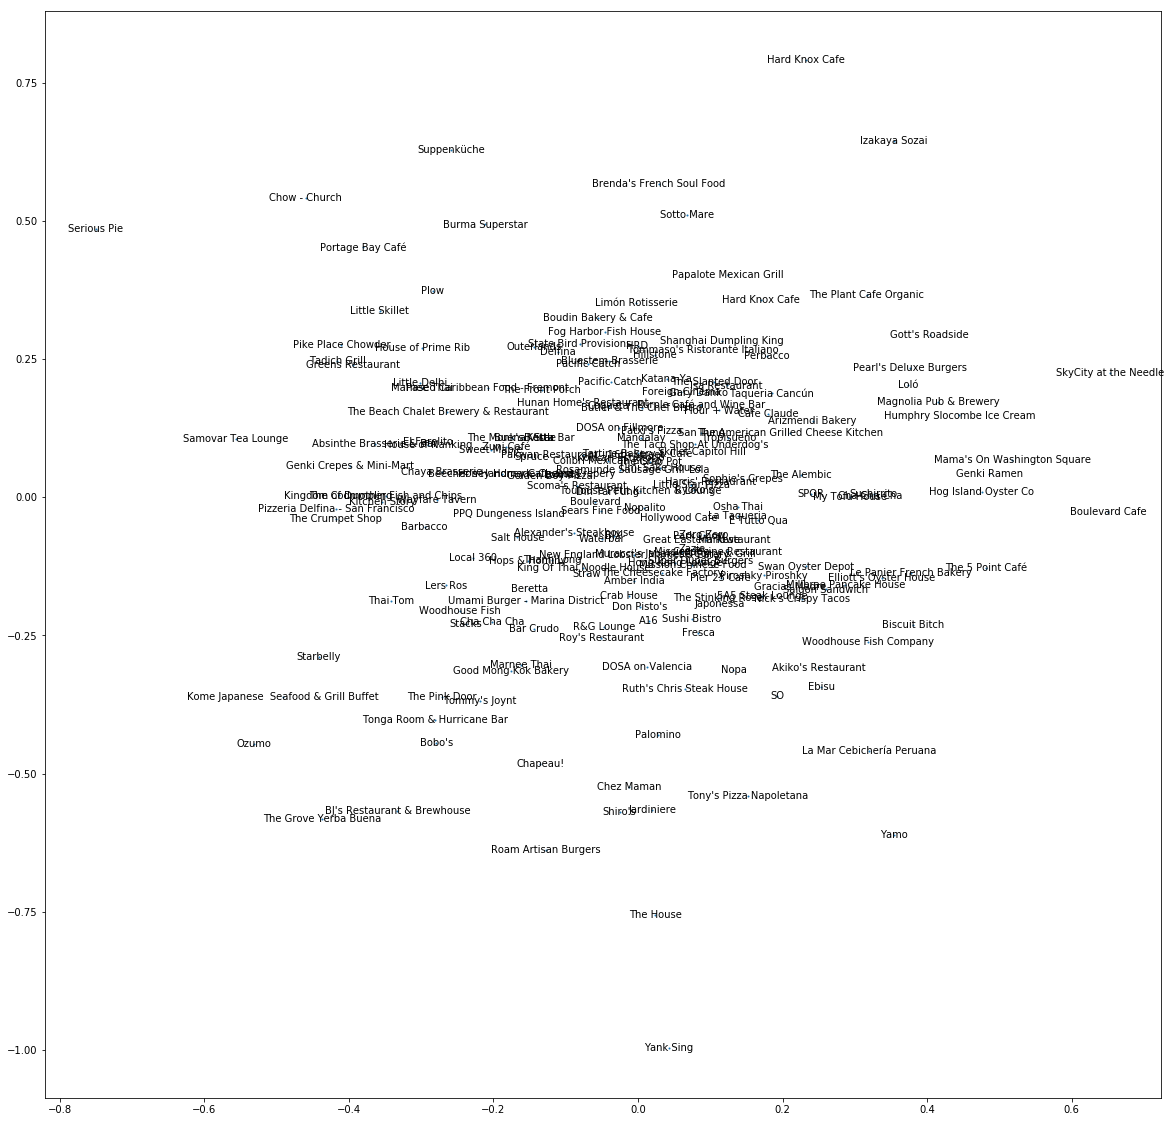

In [136]:
num_to_plot = 200
latent_feature_x = 1
latent_feature_y = 2

fig, ax = plt.subplots(1, 1, figsize=(20,20))
xs = algo.qi[:num_to_plot, latent_feature_x]
ys = algo.qi[:num_to_plot, latent_feature_y]
labels = restaurants_with_id_pdf[:num_to_plot][['name']].values.flatten()

ax.scatter(xs, ys, s=1)

for label, x, y in zip(labels, xs, ys):
    ax.text(x, y, label, horizontalalignment='center', verticalalignment='center')